# Analysis of restaurant reviews

In this notebook we analyze restaurant reviews for a city and a specific date.

In case gbq is not working you might need to update the python api client library:

```bash
sudo pip install --upgrade google-api-python-client
```

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# hide warnings. `gbq.read_gbq()` gives some
import warnings
warnings.filterwarnings('ignore')

In [26]:
import sys
sys.path.append('../scrape_save_search')

In [27]:
import load_data

In [29]:
comments = load_data.load_comments()

Requesting query... ok.
Job ID: job_C_4lx-Ijzd1G7n9yGs__tkZGbHtO
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 42% done. Elapsed 12.2 s.
  Got page: 3; 68% done. Elapsed 18.22 s.
  Got page: 4; 86% done. Elapsed 23.32 s.
  Got page: 5; 100% done. Elapsed 27.6 s.
Got 94854 rows.

Total time taken 29.15 s.
Finished at 2018-03-19 21:33:14.


In [35]:
restaurants, existing_tag_ids, elastic_tag_ids, image_tag_ids = load_data.load_restaurants(rename_cols=False)

Requesting query... ok.
Job ID: job_FrbBODMNI8WgIX-HW2I6njnB5vE_
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 100% done. Elapsed 7.08 s.
Got 20939 rows.

Total time taken 7.91 s.
Finished at 2018-03-19 22:02:09.


In [36]:
restaurants.shape

(2827, 26)

In [77]:
comments['date'] = pd.to_datetime(comments['date'])
comments['yearmonth'] = comments['date'].dt.strftime('%Y-%m')
comments['year'] = comments['date'].dt.strftime('%y')
comments['month'] = comments['date'].dt.strftime('%m')

# Pretty cols

In [49]:
restaurants.columns = [x[5:] if 'info' in x else x for x in restaurants.columns]

In [51]:
tmp = restaurants[['name', 'lat', 'lon', 'country', 'city', 'postal_code', 'street', 'house_number',
       'reviews_noise_level', 'reviews_waiting_time', 'reviews_nr_ratings']].head()

In [52]:
tmp.columns = ['Name', 'Lat', 'Lon', 'Country', 'City', 'Postal code', 'Street', 'House number',
       'Noise level', 'Waiting time', 'Number of ratings']

In [53]:
tmp

,Name,Lat,Lon,Country,City,Postal code,Street,House number,Noise level,Waiting time,Number of ratings
info_id,,,,,,,,,,,
219461,Proeflokaal A. van Wees,52.369958,4.887206,Nederland,Amsterdam,1016 AV,Herengracht,319,Precies goed,Kort,43
239171,Nooch,52.372363,4.884098,Nederland,Amsterdam,1016 DM,Reestraat,11,Precies goed,Redelijk,123
241137,"Kees. drinken, eten en drinken",52.355751,4.907490,Nederland,Amsterdam,1091 EE,Weesperzijde,44,Precies goed,Kort,129
235043,Stout,52.380082,4.892349,Nederland,Amsterdam,1013 EL,Haarlemmerstraat,73,Precies goed,Kort,91
219531,Sampurna,52.366837,4.890288,Nederland,Amsterdam,1017 AX,Singel,498,Precies goed,Kort,124


## Reviewers

In [58]:
comments.groupby('reviewer').count().name.value_counts().to_frame().sort_index()[10:].sum()

name    1344
dtype: int64

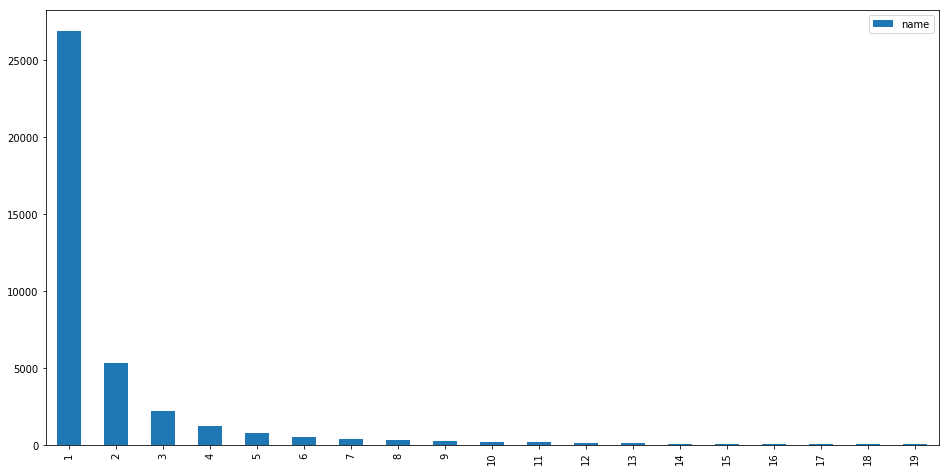

In [59]:
# number of reviews per reviewer
comments.groupby('reviewer').count().name.value_counts().to_frame().query('name>50').sort_index().plot.bar(figsize=(16,8))

## Overall review scores

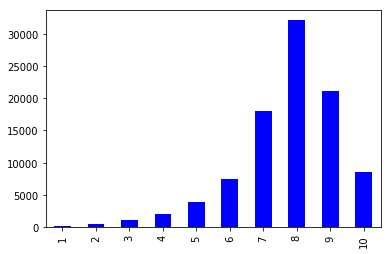

In [60]:
# Cijfer distributie
comments.rating.astype(int).value_counts().sort_index().plot.bar(color='b')

## Reviewer that use specific word

In [61]:
import re

In [62]:
word = 'slecht'
comments[word] = (
    comments
    .apply(lambda x: sum(1 for match in re.finditer(r"\b"+re.escape(word)+r"\b" , x.comment)), axis='columns')
)

In [63]:
def search_for_word(word, df, minimum_number_of_occurences=1):
    df = df.copy()
    df[word] = df.apply(lambda x: sum(1 for match in re.finditer(r"\b"+re.escape(word)+r"\b" , x.comment)), axis='columns')
    df_word = df[df[word] >= minimum_number_of_occurences]
    print(f'Total reviews with {minimum_number_of_occurences} times the word {word}:', len(df_word), f'\nTotal review overall: {len(df)}')
    df_word.rating.astype(int).value_counts().sort_index().plot.bar(color='b')

Total reviews with 1 times the word slecht: 2590 
Total review overall: 94854


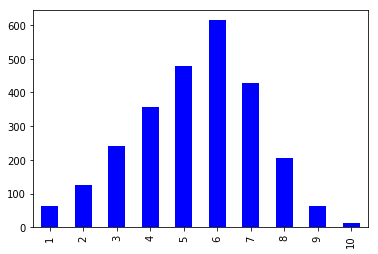

In [64]:
search_for_word('slecht', comments, minimum_number_of_occurences=1)

Total reviews with 2 times the word slecht: 225 
Total review overall: 94854


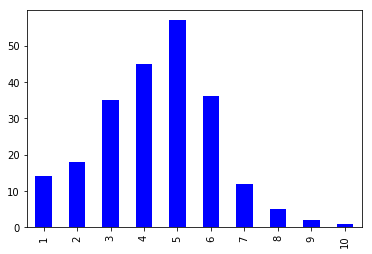

In [65]:
search_for_word('slecht', comments, minimum_number_of_occurences=2)

Total reviews with 3 times the word slecht: 31 
Total review overall: 94854


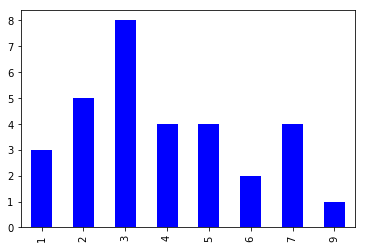

In [66]:
search_for_word('slecht', comments, minimum_number_of_occurences=3)

Total reviews with 1 times the word top: 6499 
Total review overall: 94854


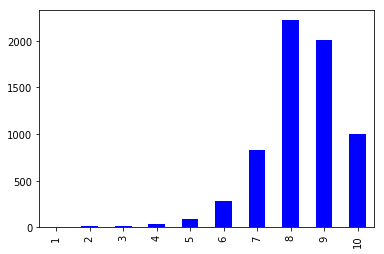

In [67]:
search_for_word('top', comments)

## More use of the word 'lekker' does not increase score

Total reviews with 1 times the word lekker: 28177 
Total review overall: 94854


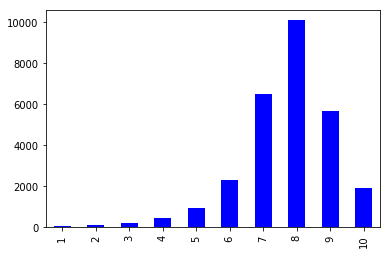

In [68]:
search_for_word('lekker', comments)

Total reviews with 2 times the word lekker: 5749 
Total review overall: 94854


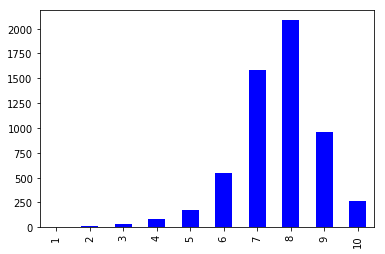

In [69]:
search_for_word('lekker', comments, minimum_number_of_occurences=2)

## Average ratings per reviewer

In [70]:
comments_mean_count_rating = comments.groupby('reviewer').agg({'rating': ['mean', 'count']})

In [72]:
# Reviewers die alleen onvoldoendes geven
comments_mean_count_rating[comments_mean_count_rating[('rating', 'mean')] < 5.5].shape

(2276, 2)

In [73]:
# Reviewers die alleen onvoldoendes geven (en meer dan 1 rating hebben gegeven)
comments_mean_count_rating[(comments_mean_count_rating[('rating', 'count')] > 1) & (comments_mean_count_rating[('rating', 'mean')] < 5.5)].shape

(197, 2)

## Reviewer with most reviews

In [74]:
comments_cnt = comments.groupby('reviewer').count()
top_reviewer = comments_cnt[comments_cnt.name == comments_cnt.name.max()].index[0]
top_reviewer

'Peter S.'

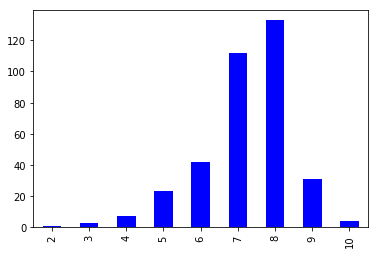

In [75]:
# Wat voor scores geeft deze reviewer
comments[comments.reviewer == top_reviewer].rating.astype(int).value_counts().sort_index().plot.bar(color='b')

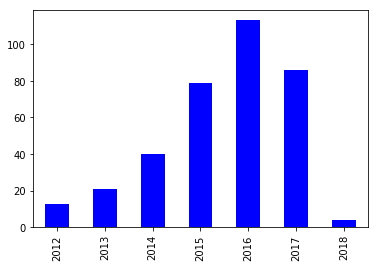

In [78]:
# In welke jaren gaf hij zijn reviews
comments[comments.reviewer == top_reviewer].date.dt.year.value_counts().sort_index().plot.bar(color='b')

# Reviews over time

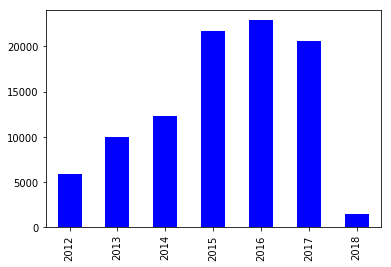

In [79]:
# totaal aantal reviews per jaar
comments.date.dt.year.value_counts().sort_index().plot.bar(color='b')

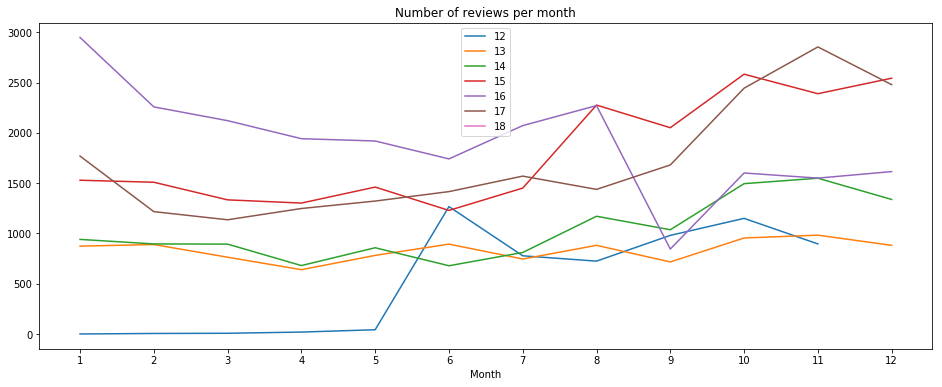

In [80]:
fig, ax = plt.subplots(1,1)

for name, grp in (
    comments
    .assign(nr_reviews=1)
    .groupby(['year', 'month'])
    .agg({'nr_reviews' : sum})
    .groupby('year')
):
    grp.nr_reviews.plot(figsize=(16,6), title='Number of reviews per month', label=name, ax=ax) 

ax.set_xlabel('Month')
ax.set_xticks(range(12))
ax.set_xticklabels(range(1,13))
ax.legend()

# Average rating over time: rating increases over time!

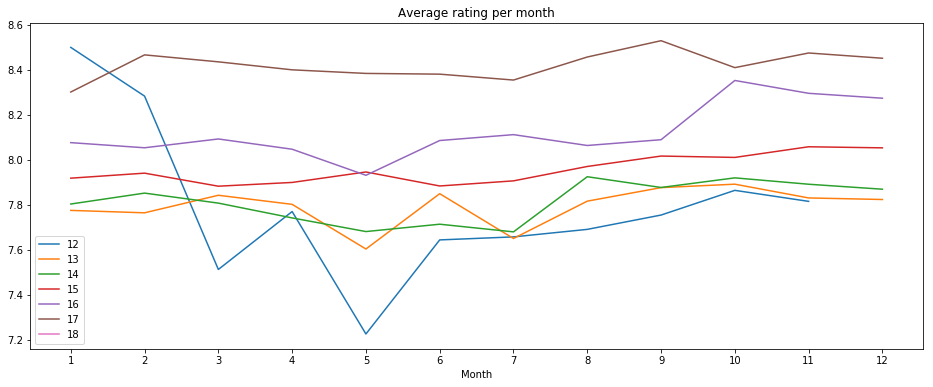

In [82]:
fig, ax = plt.subplots(1,1)

for name, grp in (
    comments
    .groupby(['year', 'month'])
    .agg({'rating' : np.mean})
    .groupby('year')
):
    grp.rating.plot(figsize=(16,6), title='Average rating per month', label=name, ax=ax) 

ax.set_xlabel('Month')
ax.set_xticks(range(12))
ax.set_xticklabels(range(1,13))
ax.legend()

## Average price distribution

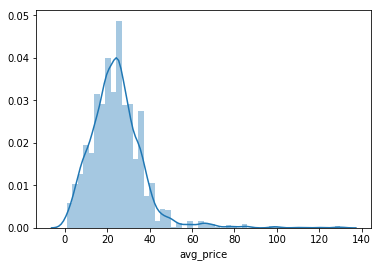

In [87]:
sns.distplot(restaurants.query('avg_price != -1')['avg_price'])